# Data Loading and Cleaning

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import scipy

In [2]:
# load data sets
crime = pd.read_csv('crime-housing-austin-2015.csv')
population = pd.read_csv('AustinZipCodes.csv')

# clean columns and set to float data types
population['Population'] = population['Population'].str.replace(",", "").astype('float')
population['People / Sq. Mile'] = population['People / Sq. Mile'].str.replace(",", "").astype('float')
population[['Latitude', 'Longitude']] = population['Location'].str.split(',', n=1, expand=True).astype('float')

# make a column indicating if its a violent crime or property crime
crime['Crime_Type'] = np.where(crime['Highest_NIBRS_UCR_Offense_Description'].isin(['Murder', 'Rape', 'Robbery', 'Agg Assault']), 'Violent_Crime', 'Property_Crime')

# remove rows where no Zip Code is given and convert to character
crime = crime.dropna(subset='Zip_Code_Crime')
crime['Zip_Code_Crime'] = crime['Zip_Code_Crime'].astype(np.int64)

In [3]:
crime.head()

,Key,Council_District,Highest_Offense_Desc,Highest_NIBRS_UCR_Offense_Description,Report_Date,Location,Clearance_Status,Clearance_Date,District,Zip_Code_Crime,...,Ownerunitsaffordabletoaverageteacher,Rentalunitsaffordabletoaveragetechworker,Ownerunitsaffordabletoaveragetechworker,Changeinpercentageofpopulationbelowpoverty2000-2012,Changeinmedianrent2000-2012,Changeinmedianhomevalue2000-2012,Percentageofhomeswithin1/4-mioftransitstop,Averagemonthlytransportationcost,Percentageofhousingandtransportationcoststhatistransportation-related,Crime_Type
0,201510782,4.0,AGG ROBBERY/DEADLY WEAPON,Robbery,1-Jan-15,9001 N IH 35 SVRD NB,N,28-Jan-15,E,78753,...,75%,100%,98%,128%,26%,40%,59%,$708,44%,Violent_Crime
1,201511231,4.0,ROBBERY BY ASSAULT,Robbery,1-Jan-15,919 E KOENIG LN SVRD EB,N,13-Jan-15,I,78751,...,10%,97%,42%,23%,38%,97%,98%,$550,40%,Violent_Crime
2,201511736,1.0,BURGLARY OF RESIDENCE,Burglary,1-Jan-15,12151 N IH 35 SVRD NB,N,13-Jan-15,E,78753,...,75%,100%,98%,128%,26%,40%,59%,$708,44%,Property_Crime
3,201511433,4.0,BURGLARY OF RESIDENCE,Burglary,1-Jan-15,1044 NORWOOD PARK BLVD,N,5-Jan-15,I,78753,...,75%,100%,98%,128%,26%,40%,59%,$708,44%,Property_Crime
4,201511936,2.0,BURGLARY OF RESIDENCE,Burglary,1-Jan-15,2413 BITTER CREEK DR,N,7-Jan-15,F,78744,...,87%,100%,100%,89%,26%,44%,63%,$708,40%,Property_Crime


In [4]:
population.head()

,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank,Latitude,Longitude
0,1,78705,"30.293474, -97.738268","Austin, Texas",26825.0,11008.66,#519,30.293474,-97.738268
1,2,78751,"30.310819, -97.722821","Austin, Texas",14005.0,5822.28,"#1,374",30.310819,-97.722821
2,3,78752,"30.331288, -97.704660","Austin, Texas",18030.0,5435.92,"#1,528",30.331288,-97.704660
3,4,78741,"30.229845, -97.715136","Austin, Texas",40661.0,5346.47,"#1,562",30.229845,-97.715136
4,5,78723,"30.305341, -97.683344","Austin, Texas",30110.0,5175.95,"#1,640",30.305341,-97.683344


# Merge Crime & Population

In [5]:
# get demographics per zip-code
demographics = crime.set_index('Zip_Code_Housing').loc[:, 'Populationbelowpovertylevel':'Percentageofhousingandtransportationcoststhatistransportation-related'].groupby('Zip_Code_Housing').agg('first').reset_index()
demographics['Zip_Code_Housing'] = demographics['Zip_Code_Housing'].astype(np.int64)

# # count crime per zip code
zip_crime_count = crime.groupby(['Zip_Code_Crime', 'Crime_Type', 'Highest_Offense_Desc', 'Highest_NIBRS_UCR_Offense_Description'], as_index=False).agg({'Key':'count'}).rename(columns={'Key':'Count'}) 

# # merge crime counts, zip code population, and demographics 
zip_crime_rate = pd.merge(zip_crime_count, population, left_on="Zip_Code_Crime", right_on='Zip Code', how='inner')
# zip_crime_rate = pd.merge(zip_crime_rate, demographics, left_on='Zip_Code_Crime', right_on='Zip_Code_Housing', how='left', validate="m:1")
zip_crime_rate['Crime_Rate'] = zip_crime_rate.Count / zip_crime_rate.Population * 100000
zip_crime_rate

,Zip_Code_Crime,Crime_Type,Highest_Offense_Desc,Highest_NIBRS_UCR_Offense_Description,Count,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank,Latitude,Longitude,Crime_Rate
0,78701,Property_Crime,AUTO THEFT,Auto Theft,72,22,78701,"30.271653, -97.741553","Austin, Texas",3855.0,2326.65,"#3,995",30.271653,-97.741553,1867.704280
1,78701,Property_Crime,BREACH OF COMPUTER SECURITY,Theft,2,22,78701,"30.271653, -97.741553","Austin, Texas",3855.0,2326.65,"#3,995",30.271653,-97.741553,51.880674
2,78701,Property_Crime,BURG NON RESIDENCE SHEDS,Burglary,1,22,78701,"30.271653, -97.741553","Austin, Texas",3855.0,2326.65,"#3,995",30.271653,-97.741553,25.940337
3,78701,Property_Crime,BURGLARY NON RESIDENCE,Burglary,61,22,78701,"30.271653, -97.741553","Austin, Texas",3855.0,2326.65,"#3,995",30.271653,-97.741553,1582.360571
4,78701,Property_Crime,BURGLARY OF COIN-OP MACHINE,Theft,2,22,78701,"30.271653, -97.741553","Austin, Texas",3855.0,2326.65,"#3,995",30.271653,-97.741553,51.880674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,78759,Violent_Crime,DEADLY CONDUCT,Agg Assault,4,15,78759,"30.400789, -97.755969","Austin, Texas",40547.0,2998.68,"#3,199",30.400789,-97.755969,9.865095
988,78759,Violent_Crime,RAPE,Rape,5,15,78759,"30.400789, -97.755969","Austin, Texas",40547.0,2998.68,"#3,199",30.400789,-97.755969,12.331369
989,78759,Violent_Crime,RAPE OF A CHILD,Rape,2,15,78759,"30.400789, -97.755969","Austin, Texas",40547.0,2998.68,"#3,199",30.400789,-97.755969,4.932547
990,78759,Violent_Crime,ROBBERY BY ASSAULT,Robbery,5,15,78759,"30.400789, -97.755969","Austin, Texas",40547.0,2998.68,"#3,199",30.400789,-97.755969,12.331369


## Overall Crime Rates

In [6]:
overall_crime_rate = zip_crime_rate.groupby('Zip_Code_Crime', as_index=False).agg({'Crime_Rate':'sum'})
overall_crime_rate = pd.merge(overall_crime_rate, demographics, left_on='Zip_Code_Crime', right_on='Zip_Code_Housing', how='left')
overall_crime_rate.head()

,Zip_Code_Crime,Crime_Rate,Zip_Code_Housing,Populationbelowpovertylevel,Medianhouseholdincome,Non-WhiteNon-HispanicorLatino,HispanicorLatinoofanyrace,Populationwithdisability,Unemployment,Largehouseholds(5+members),...,Rentalunitsaffordabletoaverageteacher,Ownerunitsaffordabletoaverageteacher,Rentalunitsaffordabletoaveragetechworker,Ownerunitsaffordabletoaveragetechworker,Changeinpercentageofpopulationbelowpoverty2000-2012,Changeinmedianrent2000-2012,Changeinmedianhomevalue2000-2012,Percentageofhomeswithin1/4-mioftransitstop,Averagemonthlytransportationcost,Percentageofhousingandtransportationcoststhatistransportation-related
0,78701,54552.529183,78701.0,20%,$68152,16%,14%,10%,9%,0%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
1,78702,7402.147865,78702.0,33%,$34734,18%,56%,14%,11%,10%,...,80%,15%,99%,67%,3%,73%,207%,96%,$590,39%
2,78703,3768.189941,78703.0,10%,$92606,9%,9%,6%,4%,4%,...,51%,2%,92%,13%,7%,65%,104%,67%,$629,25%
3,78704,5944.646119,78704.0,21%,$50248,7%,30%,9%,7%,3%,...,76%,13%,99%,33%,33%,40%,126%,76%,$629,33%
4,78705,5017.707363,78705.0,66%,$11917,21%,17%,4%,14%,2%,...,57%,38%,94%,79%,49%,70%,40%,100%,$511,30%


## Violent vs Property Crime Rates

In [7]:
violent_crime_rate = zip_crime_rate.groupby(['Zip_Code_Crime', 'Crime_Type'], as_index=False).agg({'Crime_Rate':'sum'})
violent_crime_rate = pd.merge(violent_crime_rate, demographics, left_on='Zip_Code_Crime', right_on='Zip_Code_Housing', how='left')
violent_crime_rate.head()

,Zip_Code_Crime,Crime_Type,Crime_Rate,Zip_Code_Housing,Populationbelowpovertylevel,Medianhouseholdincome,Non-WhiteNon-HispanicorLatino,HispanicorLatinoofanyrace,Populationwithdisability,Unemployment,...,Rentalunitsaffordabletoaverageteacher,Ownerunitsaffordabletoaverageteacher,Rentalunitsaffordabletoaveragetechworker,Ownerunitsaffordabletoaveragetechworker,Changeinpercentageofpopulationbelowpoverty2000-2012,Changeinmedianrent2000-2012,Changeinmedianhomevalue2000-2012,Percentageofhomeswithin1/4-mioftransitstop,Averagemonthlytransportationcost,Percentageofhousingandtransportationcoststhatistransportation-related
0,78701,Property_Crime,48482.490272,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
1,78701,Violent_Crime,6070.038911,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
2,78702,Property_Crime,6656.607793,78702.0,33%,$34734,18%,56%,14%,11%,...,80%,15%,99%,67%,3%,73%,207%,96%,$590,39%
3,78702,Violent_Crime,745.540073,78702.0,33%,$34734,18%,56%,14%,11%,...,80%,15%,99%,67%,3%,73%,207%,96%,$590,39%
4,78703,Property_Crime,3630.329334,78703.0,10%,$92606,9%,9%,6%,4%,...,51%,2%,92%,13%,7%,65%,104%,67%,$629,25%


## Collpased Crime Rates

In [8]:
collapsed_crime_rate = zip_crime_rate.groupby(['Zip_Code_Crime', 'Highest_NIBRS_UCR_Offense_Description'], as_index=False).agg({'Crime_Rate':'sum'})
collapsed_crime_rate = pd.merge(collapsed_crime_rate, demographics, left_on='Zip_Code_Crime', right_on='Zip_Code_Housing', how='left')
collapsed_crime_rate.head()

,Zip_Code_Crime,Highest_NIBRS_UCR_Offense_Description,Crime_Rate,Zip_Code_Housing,Populationbelowpovertylevel,Medianhouseholdincome,Non-WhiteNon-HispanicorLatino,HispanicorLatinoofanyrace,Populationwithdisability,Unemployment,...,Rentalunitsaffordabletoaverageteacher,Ownerunitsaffordabletoaverageteacher,Rentalunitsaffordabletoaveragetechworker,Ownerunitsaffordabletoaveragetechworker,Changeinpercentageofpopulationbelowpoverty2000-2012,Changeinmedianrent2000-2012,Changeinmedianhomevalue2000-2012,Percentageofhomeswithin1/4-mioftransitstop,Averagemonthlytransportationcost,Percentageofhousingandtransportationcoststhatistransportation-related
0,78701,Agg Assault,2723.735409,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
1,78701,Auto Theft,1867.704280,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
2,78701,Burglary,2049.286641,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
3,78701,Murder,25.940337,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%
4,78701,Rape,1011.673152,78701.0,20%,$68152,16%,14%,10%,9%,...,29%,7%,90%,30%,12%,115%,59%,97%,$433,23%


# Analysis

## Distribution of Crime Rate

<Axes: xlabel='Crime_Rate', ylabel='Count'>

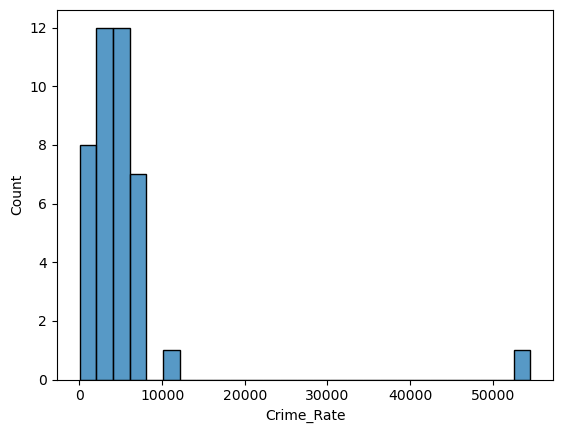

In [9]:
sns.histplot(data=overall_crime_rate, x='Crime_Rate')

## Violent Crime Vs Property Crime

PearsonRResult(statistic=0.5834033094786832, pvalue=0.0001208872335457005)

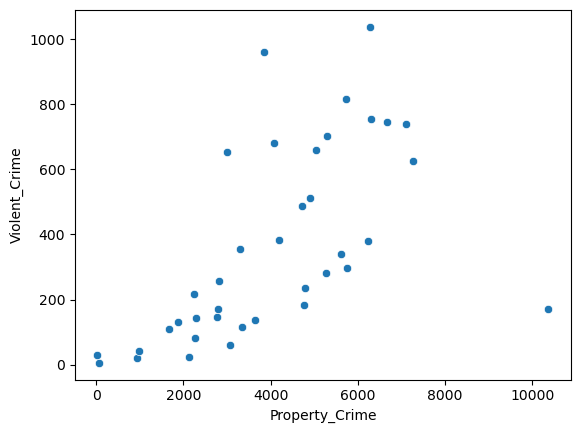

In [10]:
violent_crime_rate_wide = violent_crime_rate.loc[violent_crime_rate.Zip_Code_Crime != 78701, :].pivot(index='Zip_Code_Crime', columns='Crime_Type', values='Crime_Rate').dropna() # remove the outlier
sns.scatterplot(violent_crime_rate_wide, x='Property_Crime', y='Violent_Crime')
scipy.stats.pearsonr(violent_crime_rate_wide.Property_Crime, violent_crime_rate_wide.Violent_Crime)

## Does higher property crime rate correlate with lower income? 

In [11]:
property_v_income = violent_crime_rate.loc[violent_crime_rate.Crime_Type == 'Property_Crime', ['Zip_Code_Crime', 'Crime_Rate', 'Medianhouseholdincome']]
property_v_income['Medianhouseholdincome'] = property_v_income['Medianhouseholdincome'].str.replace('$', '').astype('float')
property_v_income = property_v_income.dropna()
property_v_income = property_v_income.loc[property_v_income.Zip_Code_Crime != 78701] # renomve the extreme outlier

PearsonRResult(statistic=-0.6245388256474569, pvalue=7.887946869203953e-05)

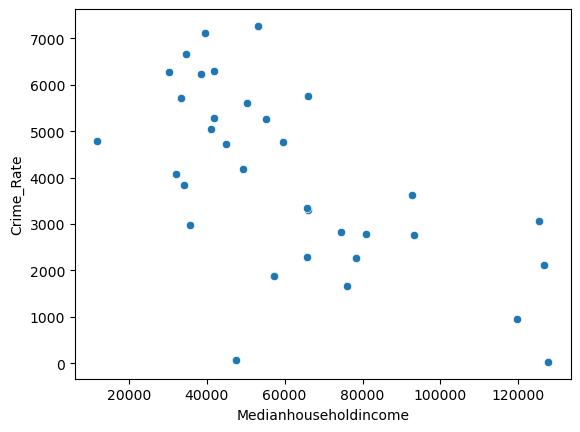

In [12]:
sns.scatterplot(data=property_v_income, x='Medianhouseholdincome', y ='Crime_Rate')
scipy.stats.pearsonr(property_v_income.Crime_Rate, property_v_income.Medianhouseholdincome)

## Do more dense Zip codes havea higher crime rate than the less dense zip codes?

In [13]:
density_crimeRate = zip_crime_rate.groupby('Zip_Code_Crime', as_index=False).agg({'Crime_Rate':'sum', 'People / Sq. Mile': 'first', 'Latitude':'first', 'Longitude':'first'})
density_crimeRate['density'] = np.where(density_crimeRate['People / Sq. Mile'] > 2000, 'Over 2,000 People / Sq. Mile', "Under 2,000 People / Sq. Mile")
density_crimeRate = density_crimeRate.loc[density_crimeRate.Zip_Code_Crime != 78701, :]

density
Over 2,000 People / Sq. Mile     21
Under 2,000 People / Sq. Mile    19
Name: count, dtype: int64


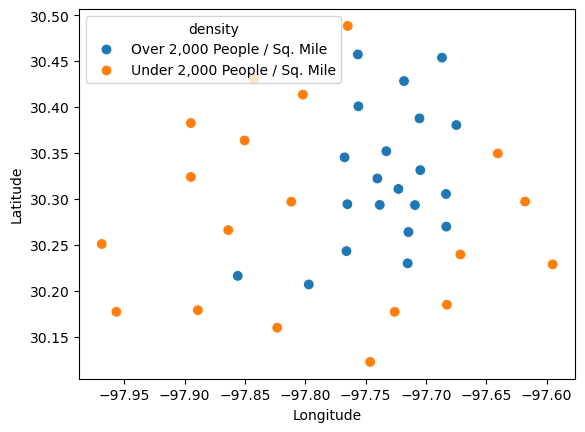

In [14]:
sns.scatterplot(data = density_crimeRate, x='Longitude', y='Latitude', hue='density', s=60)
print(density_crimeRate.value_counts('density'))

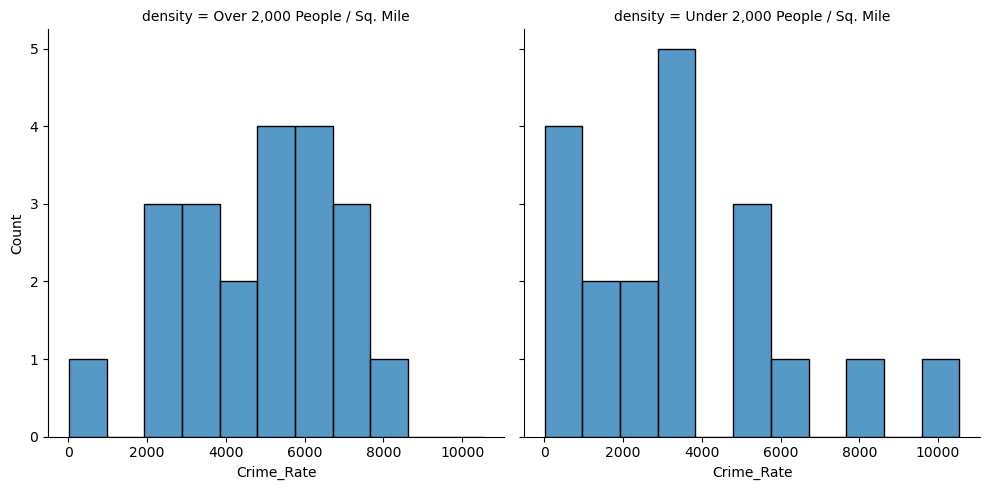

In [15]:
sns.displot(data=density_crimeRate, x="Crime_Rate", col="density", binwidth=1000)

In [16]:
density_crimeRate.groupby('density').agg(['mean', 'std'])

Zip_Code_Crime              Crime_Rate  \
                                        mean        std         mean   
density                                                                
Over 2,000 People / Sq. Mile    78734.095238  19.826509  4847.452231   
Under 2,000 People / Sq. Mile   78736.000000  10.728985  3435.577711   

                                           People / Sq. Mile               \
                                       std              mean          std   
density                                                                     
Over 2,000 People / Sq. Mile   2064.949594       4251.508095  1902.012733   
Under 2,000 People / Sq. Mile  2796.098117        655.820000   562.245214   

                                Latitude            Longitude            
                                    mean       std       mean       std  
density                                                                  
Over 2,000 People / Sq. Mile   30.323119  0.074319 -97.732992  0.043193  
Under 2,000 People / Sq. Mile  30.280562  0.103766 -97.791690  0.112406

In [17]:
low_density_rates = density_crimeRate.loc[density_crimeRate['density'] == 'Under 2,000 People / Sq. Mile', 'Crime_Rate']
high_density_rates = density_crimeRate.loc[density_crimeRate['density'] == 'Over 2,000 People / Sq. Mile', 'Crime_Rate']
# scipy.stats.mannwhitneyu(low_density_rates, high_density_rates)
scipy.stats.ttest_ind(low_density_rates, high_density_rates)

TtestResult(statistic=-1.8284501187555728, pvalue=0.0753397968161439, df=38.0)

## What's up with Zip Code 78701?

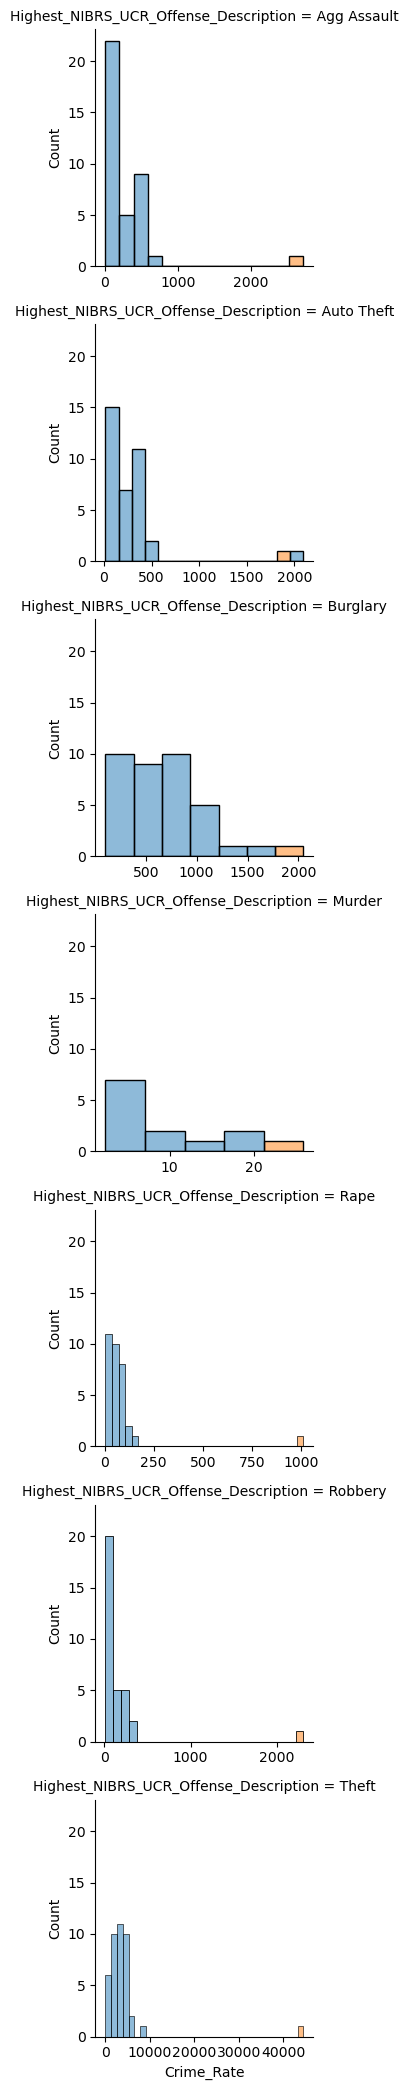

In [18]:
highlights = zip_crime_rate.copy()
highlights_collapsed = highlights.groupby(['Zip_Code_Crime', 'Highest_NIBRS_UCR_Offense_Description'], as_index=False).agg({'Crime_Rate':'sum'})
highlights_collapsed['outlier'] = highlights_collapsed['Zip_Code_Crime'] == 78701
g = sns.FacetGrid(highlights_collapsed, row='Highest_NIBRS_UCR_Offense_Description', sharex=False)
g.map_dataframe(sns.histplot, x='Crime_Rate', hue='outlier')